In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

In [2]:
def read_matlab_file_with_BGO_data(matlabfilename):
    '''Read matlab file with ASIM BGO data from the high energy detector (HED)

    tus: relative time in microseconds
    erg: energy channel (needs to be calibrated to keV using calibration coeff from https://git.app.uib.no/ASIM-MXGS/IN-FLIGHT_CALIBRATION_BGO/-/tree/master/CALIBRATION_COEFS )
    typ: normal, fast, valley, or overflow event
    adr: BGO address 1-12
    dau: dau address 1-4
    det: detector address 1-3
    DetCol: RGB color
    '''
    matlabfile_TGF = '/Users/andreas/phys/master/MATLAB/output/file_mat_TGF/%s' % matlabfilename

    mat = scipy.io.loadmat(matlabfile_TGF)
    tus = mat['tus'].flatten()
    erg = mat['erg'].flatten()
    DetCol = mat['DetCol']
    adr = mat['adr'].flatten()
    dau = mat['dau'].flatten()
    det = mat['det'].flatten()
    typ = mat['typ'].flatten()
    return tus, erg, typ, adr, dau, det, DetCol


def read_matlab_file_with_CZT_data(filename):
    '''Read matlab file with ASIM CZT data from the low energy detector (LED)

    tus: relative time in microseconds (excluded multihits)
    erg: energy channel (excluded multihits)
    energy_keV: energy in keV (excluded multihits)
    tus_keep_multihit: relative time in microseconds (included multihits)
    erg_keep_multihit: energy channel (included multihits)
    multihit_indx: multihit index 0-4.o
    '''
    mat = scipy.io.loadmat("/Users/andreas/phys/master/MATLAB/CZT_calibration/file_mat_CZT_TGF/%s.mat" % (filename))

    #keV_spectra = mat['keV_spectra_total_fulltrigger']

    # Included multihits. Important for light curves
    tus_keep_multihit = np.array(mat['tus_keep_multihit_fulltrigger'])[:,0] # relative time in microseconds
    erg_keep_multihit = np.array(mat['erg_keep_multihit_fulltrigger'])[0,:] # energy channel (unreliable for multi hits)
    multihit_indx = np.array(mat['multihit_fulltrigger'])[0,:] # multihit index. How many multihits in count. (0=1 count, 1=2 counts, 2=3 counts...)


    # The multihits are removed as they don't have a reliable energy estimate
    erg = np.array(mat['erg_fulltrigger'])[0,:] # energy channel of CZT pixel
    tus = np.array(mat['tus_fulltrigger'])[:,0] # relative time in microseconds
    energy_keV = np.array(mat['pixel_energy_fulltrigger']).flatten() # energy in keV of CZT pixel

    return tus, erg, energy_keV, tus_keep_multihit, erg_keep_multihit, multihit_indx

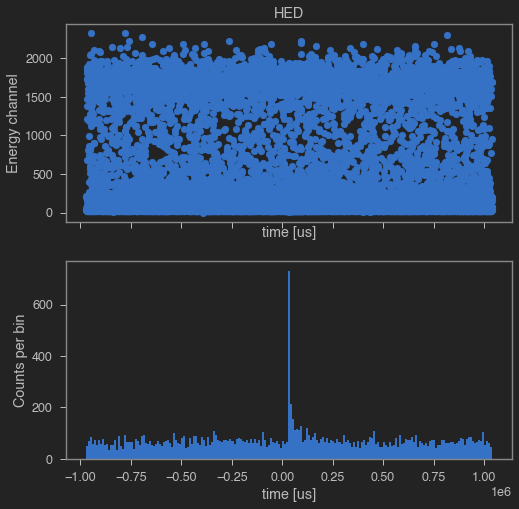

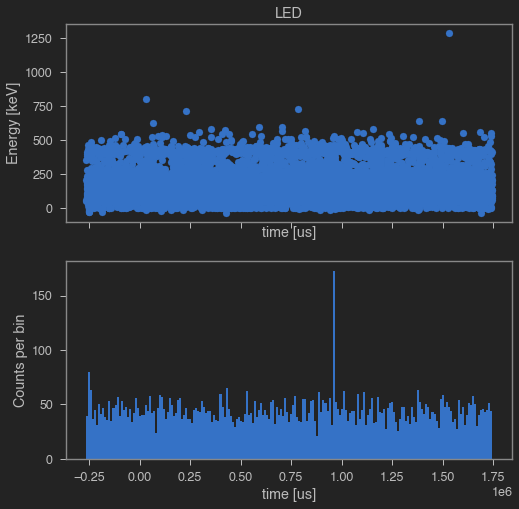

In [3]:
def main(filename):
    # output array for tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED må modifiseres

    os.mkdir("/Users/andreas/phys/master/MATLAB/output/output_plots/{}".format(filename))
    
    tus_LED, erg_LED, energy_keV_LED, tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED = read_matlab_file_with_CZT_data("2019.Sep.03_18.51.57.085569_Fulltrigger")

    tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED = read_matlab_file_with_BGO_data(filename)


    fig0,(ax0, ax1) =  plt.subplots(2,1, figsize=(8,8), sharex=True, sharey=False)
    ax0.set_title("HED")

    ax0.scatter(tus_HED, erg_HED)
    ax0.set_xlabel("time [us]")
    ax0.set_ylabel("Energy channel")

    binsize = 10000 # us --> 10 ms bin
    ax1.hist(tus_HED, bins=np.arange(min(tus_HED), max(tus_HED)+binsize, binsize))
    ax1.set_xlabel("time [us]")
    ax1.set_ylabel("Counts per bin")
    
    plt.savefig("/Users/andreas/phys/master/MATLAB/output/output_plots/{}/{}_HED".format(filename,filename))


    fig0,(ax0, ax1) =  plt.subplots(2,1, figsize=(8,8), sharex=True, sharey=False)
    ax0.set_title("LED")
    ax0.scatter(tus_LED, energy_keV_LED)
    ax0.set_xlabel("time [us]")
    ax0.set_ylabel("Energy [keV]")

    binsize = 10000 # us --> 10 ms bin
    ax1.hist(tus_LED, bins=np.arange(min(tus_LED), max(tus_LED)+binsize, binsize))
    ax1.set_xlabel("time [us]")
    ax1.set_ylabel("Counts per bin")

    plt.savefig("/Users/andreas/phys/master/MATLAB/output/output_plots/{}/{}_LED".format(filename,filename))
    plt.show()
    

main("2020_04_15_08_48_05")